In [2]:
# physics 411 assignment 4 code for Q1 and Q3

# import libraries:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
from scipy.stats import norm
import datetime 
import matplotlib.dates as mdates
from scipy import interpolate
import matplotlib.ticker as plticker
from scipy import signal
from scipy.stats.distributions import chi2
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial

Question 1. Power spectral density
1. Read in the hour-resolution temperature and pressure data sets for the Station “RVYC”
    (48.4519oN, 236.704oE). Consider two data segments:
    * i) data from 15 November 2019 to 15 February 2020, only
     * ii) data from 1 June 2021 to 1 September 2021, only.
     
   Remove the means from the data sets.
   You may use built-in routines, ( e.g. pwelch.m or scipy.signal.welch or similar, but convince
   yourself that you understand what they are doing.) Please clearly state your choices for the
   optional input parameters, and include your code. For both variables (T and p) do the following:
   
    * a) Calculate the power spectral density Γ(f) based on the Welch method, using a Hanning
      window, and 50% overlap. Choose a reasonable segment length, NFFT, and justify your
      choice.
      Plot the results on a log-log scale, with frequencies given in “cycles per day” [cpd]. Include
      confidence limits, and make sure the figures have an adequate size and are not too busy.
    * b) Discuss the results for each variable, and compare results for T and p.
    * c) Plot summer and winter psd’s on the same figure in a variance-preserving form, i.e.
       plot f Γ(f) in linear-scale vs. log10 f. (Don’t include confidence limits). Explain (i.e.
       theoretical derivation) why this form is “variance preserving”.
    * d) Test Parserval’s theorem quantitatively (for the 2 temperature data segments, only).

In [3]:
# first we need to read in the correct hourly temperature data:

hourly_temp =np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_temperature_hourly.dat").T
hourly_pressure = np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_pressure_hourly.dat").T

time = hourly_temp[0]
rvyc_htt = hourly_temp[10]
rvyc_hpt = hourly_pressure[10]

# clean up header
rvyc_htt = rvyc_htt[3:]
rvyc_hpt = rvyc_hpt[3:]
time = time[3:]

In [4]:
# code to find the range of data for the requisite dates:

# time parameters:

time_2_15nov19 = 437160 # hrs
time_2_15feb20 = 439368 # hrs
time_2_1jun21 = 450696 # hrs
time_2_1sept21 = 452904 # hrs

length_w = time_2_15feb20 - time_2_15nov19
length_s = time_2_1sept21 - time_2_1jun21

initial_time = 16801 * 24 # hrs

diff_15nov19 = (time_2_15nov19 - initial_time)
diff_1jun21 = (time_2_1jun21 - initial_time)

# final data sets:

rvyc_htw = rvyc_htt[diff_15nov19:diff_15nov19 + length_w]
rvyc_hts = rvyc_htt[diff_1jun21:diff_1jun21 + length_s]

rvyc_hpw = rvyc_hpt[diff_15nov19:diff_15nov19 + length_w]
rvyc_hps = rvyc_hpt[diff_1jun21:diff_1jun21 + length_s]

time_w = time[diff_15nov19:diff_15nov19 + length_w]
time_s = time[diff_1jun21:diff_1jun21 + length_s]

time_plw = time_w + initial_time/24
time_pls = time_s + initial_time/24

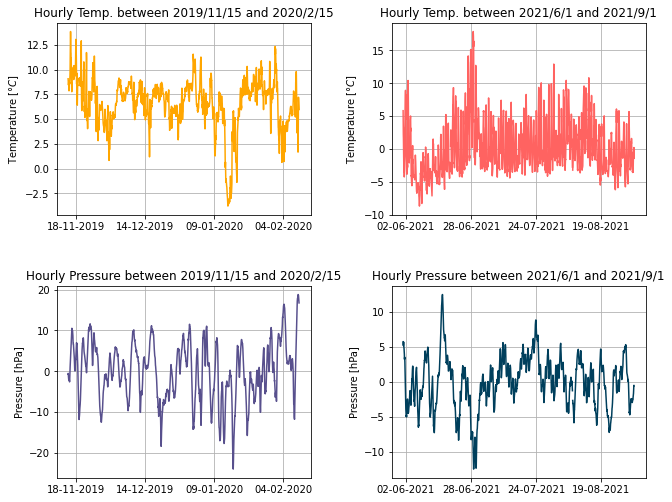

In [5]:
# now want to plot the time series to see if all of the ducks are in a row:

# zero mean data sets:

# means: (using nanmean as some values in this range are not numbers)

mtw = np.nanmean(rvyc_htw); mts = np.nanmean(rvyc_hts)
mpw = np.nanmean(rvyc_hpw); mps = np.nanmean(rvyc_hps)

rvyc_ztw = (rvyc_htw - mtw); rvyc_zts = (rvyc_hts - mts)
rvyc_zpw = (rvyc_hpw - mpw); rvyc_zps = (rvyc_hps - mps)

# plots the time series to ensure correct data:

width=10
height=8
ff, (ax) = plt.subplots(2, 2)
ff.set_figwidth(width)
ff.set_figheight(8)
ff.tight_layout(pad=5.0)

# plots the hourly temp data in winter:
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[0,0].xaxis.set_major_locator(mdates.DayLocator(interval=int(2.6*width)))
ax[0,0].plot(time_plw, rvyc_htw, color='#ffa600')
ax[0,0].set_title("Hourly Temp. between 2019/11/15 and 2020/2/15")
ax[0,0].set_ylabel(r"Temperature [$\degree C$]" )
ax[0,0].grid(True)


# plots the hourly temp data in summer:
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=int(2.6*width)))
ax[0,1].plot(time_pls, rvyc_zts, color='#ff6361')
ax[0,1].set_title("Hourly Temp. between 2021/6/1 and 2021/9/1")
ax[0,1].set_ylabel(r"Temperature [$\degree C$]" )
ax[0,1].grid(True)


# plots the hourly pressure data in winter:
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[1,0].xaxis.set_major_locator(mdates.DayLocator(interval=int(2.6*width)))
ax[1,0].plot(time_plw, rvyc_zpw, color='#58508d')
ax[1,0].set_title("Hourly Pressure between 2019/11/15 and 2020/2/15")
ax[1,0].set_ylabel(r"Pressure [hPa]" )
ax[1,0].grid(True)

# plots the hourly pressure data in summer:
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[1,1].xaxis.set_major_locator(mdates.DayLocator(interval=int(2.6*width)))
ax[1,1].plot(time_pls, rvyc_zps, color='#003f5c')
ax[1,1].set_title("Hourly Pressure between 2021/6/1 and 2021/9/1")
ax[1,1].set_ylabel(r"Pressure [hPa]" )
ax[1,1].grid(True)



In [6]:
# we now wish to find the power spectral density using the welch method: length of data is 2208 hrs

# parameter choices:

# the choice of nfft is the one parameter up to interpretation. It is not unreasonable to have NS>=8 
# hanning windows, which correspond to a number of data points of ~512. It is important for this
# number to be able to adequately resolve the known density at a frequency of one cpd.

# the other thing to account for is the reduced size of the data sets after removing the Nan 
# values. The lengths are now [2089, 2186, 2089, 2206] and so a value of 256 for all of them
# is appropriate for NS~8 and so M=2NS-1 --->  M = 15 

nfft = 2**8 # length of points in each window  
window = "hann"  # python argument for hanning window
overlap = nfft / 2 # will give an overlap of 50% of the windows points
fsamp = 24 # samples per day

# In order for us to utilize the welch method we must remove all NaN values from
# the data. This can be done with some interpolation scheme to replace
# any missing values. For the sake of brevity, we will remove these missing data points:

rvyc_ntw = [i for i in rvyc_ztw if np.isnan(i) == False]
rvyc_nts = [i for i in rvyc_zts if np.isnan(i) == False]

rvyc_npw = [i for i in rvyc_zpw if np.isnan(i) == False]
rvyc_nps = [i for i in rvyc_zps if np.isnan(i) == False]

# need time vectors corresponding to winter and summer temps:

time_ntw = [time_plw[t] for t in range(len(time_plw)) if np.isnan(rvyc_ztw[t]) ==False]
time_nts = [time_pls[t] for t in range(len(time_pls)) if np.isnan(rvyc_zts[t]) ==False]

# now the frequency and power spectral densities are given by the welch method:

freq_htw, pxx_htw = signal.welch(rvyc_ntw, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)
freq_hts, pxx_hts = signal.welch(rvyc_nts, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)

freq_hpw, pxx_hpw = signal.welch(rvyc_npw, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)
freq_hps, pxx_hps = signal.welch(rvyc_nps, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)



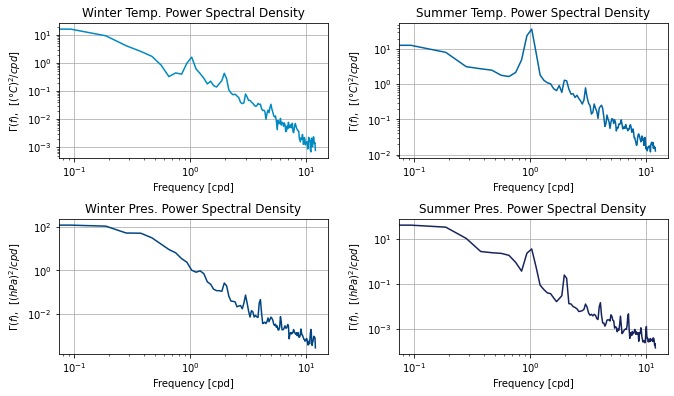

In [7]:
# plots the four power spectral densities:

width=10
height=6
ff, (ax) = plt.subplots(2, 2)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)


ax[0,0].loglog(freq_htw, pxx_htw, color='#008ac2')
ax[0,0].set_title("Winter Temp. Power Spectral Density")
ax[0,0].set_ylabel(r"$\Gamma(f)$,  $ [(\degree C)^2/cpd]$")
ax[0,0].set_xlabel("Frequency [cpd]")
ax[0,0].grid(True)

ax[0,1].loglog(freq_hts, pxx_hts, color='#0066a4')
ax[0,1].set_title("Summer Temp. Power Spectral Density")
ax[0,1].set_ylabel(r"$\Gamma(f)$,  $ [(\degree C)^2/cpd]$")
ax[0,1].set_xlabel("Frequency [cpd]")
ax[0,1].grid(True)

ax[1,0].loglog(freq_hpw, pxx_hpw, color='#004481')
ax[1,0].set_title("Winter Pres. Power Spectral Density")
ax[1,0].set_ylabel(r"$\Gamma(f)$,  $ [(hPa)^2/cpd]$")
ax[1,0].set_xlabel("Frequency [cpd]")
ax[1,0].grid(True)

ax[1,1].loglog(freq_hps, pxx_hps, color='#17245c')
ax[1,1].set_title("Summer Pres. Power Spectral Density")
ax[1,1].set_ylabel(r"$\Gamma(f)$,  $ [(hPa)^2/cpd]$")
ax[1,1].set_xlabel("Frequency [cpd]")
ax[1,1].grid(True)




We now wish to consider the uncertainties present on the above density profiles. For a welch method periodogram, the real and imaginary parts of the spectrum are both random variables and as such we have:

$$
\Gamma (f) = \frac{1}{T} [\Re (X)^2 + \Im (X)^2]
$$

Since $\Re (X)$ and $\Im (X)$ are random $\textit{Gaussian}$ distributed variables, we get that adding them quadratically yields a chi-squared distributed random variable $\Gamma$. Thus, it is possible to set upper and lower uncertainty bounds on Gamma with an inverse chi-square with degrees of freedom as follows:

$$
\frac{\nu}{inv(\chi^2_{\nu,1-\alpha/2})} \hat{\Gamma}(f) \le \Gamma_{True}(f) \le \frac{\nu}{inv(\chi^2_{\nu,\alpha/2})} \hat{\Gamma}(f)
$$

We can then implement this in python accordingly.

In [8]:
# we are now going to add the confidence intervals for the 
# four PSD from previously: (chosen interval is 95%)

confidence = 0.95
alp = 1 - confidence

# degrees of freedom correspond to number of realizations
# from the Welch method before, using 4/3 factor as it is tapered window:

NS = int(len(rvyc_hts)/nfft); M = (2*NS - 1); DOF = (4/3) * M

invchi2 = chi2.ppf([alp / 2, 1 - alp / 2], df=DOF)

bounds = DOF/invchi2

# upper and lower bounds on the PSD functions:

pxx_htw_l = bounds[0] * pxx_htw
pxx_htw_u = bounds[1] * pxx_htw

pxx_hts_l = bounds[0] * pxx_hts
pxx_hts_u = bounds[1] * pxx_hts

pxx_hpw_l = bounds[0] * pxx_hpw
pxx_hpw_u = bounds[1] * pxx_hpw

pxx_hps_l = bounds[0] * pxx_hps
pxx_hps_u = bounds[1] * pxx_hps

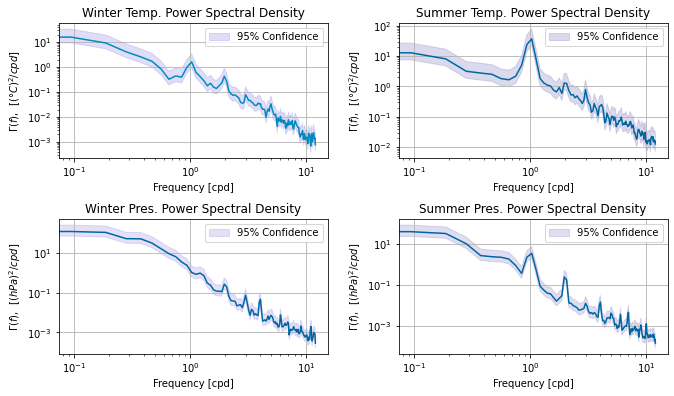

In [9]:
# plots the four power spectral densities:

width=10
height=6
ff, (ax) = plt.subplots(2,2)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)
ax1=ax[0,0];ax2=ax[0,1]
ax3=ax[1,0];ax4=ax[1,1]

ax1.loglog(freq_htw, pxx_htw, color='#008ac2')
ax1.fill_between(freq_htw, pxx_htw_l, pxx_htw_u, color='#665ed7',alpha=0.2, label="95% Confidence")
ax1.set_title("Winter Temp. Power Spectral Density")
ax1.set_ylabel(r"$\Gamma(f)$,  $ [(\degree C)^2/cpd]$")
ax1.set_xlabel("Frequency [cpd]")
ax1.legend()
ax1.grid(True)


ax2.loglog(freq_hts, pxx_hts, color='#0066a4')
ax2.fill_between(freq_hts, pxx_hts_l, pxx_hts_u, color='#4f49a7',alpha=0.2, label="95% Confidence")
ax2.set_title("Summer Temp. Power Spectral Density")
ax2.set_ylabel(r"$\Gamma(f)$,  $ [(\degree C)^2/cpd]$")
ax2.set_xlabel("Frequency [cpd]")
ax2.legend()
ax2.grid(True)

ax3.loglog(freq_hpw, pxx_hpw, color='#0066a4')
ax3.fill_between(freq_hpw, pxx_hpw_l, pxx_hpw_u, color='#7566d7',alpha=0.2, label="95% Confidence")
ax3.set_title("Winter Pres. Power Spectral Density")
ax3.set_ylabel(r"$\Gamma(f)$,  $ [(hPa)^2/cpd]$")
ax3.set_xlabel("Frequency [cpd]")
ax3.legend()
ax3.grid(True)

ax4.loglog(freq_hps, pxx_hps, color='#0066a4')
ax4.fill_between(freq_hps, pxx_hps_l, pxx_hps_u, color='#6255b4',alpha=0.2, label="95% Confidence")
ax4.set_title("Summer Pres. Power Spectral Density")
ax4.set_ylabel(r"$\Gamma(f)$,  $ [(hPa)^2/cpd]$")
ax4.set_xlabel("Frequency [cpd]")
ax4.legend()
ax4.grid(True)

We can now compare the four power spectral densities found. All of the spectra show similar qualitative behaviour. We have the most energy present at the lowest frequencies which decays rather smoothly until after a single cycle per day where they all fall off and become much noisier. As expected, the spectra is truncated at the nyquist frequency of 12 cycles per day in each case. In comparing the temperature spectra, we have clearly defined peaks at a cycle per day in both the summer and winter. In the summer, this peak is far more pronounced, exceeding the power from the small frequencies. In the winter, there is another small peak at ~2 cycles per day and an even smaller one at ~3. This is also seen in the summer temperature profile but with less relative increase at those frequencies. As the daily cycle in temperature is not a smooth sine wave in these intervals, these other peaks are likely due to higher harmonic contributions. The peaks in both temperature sets are considerably larger with respect to the uncertainty ranges supllied by the random variable ditributions. The higher harmonic fluctuations become closer to the uncertainty range and could be conceivably considered to be insignificant. The same analysis is true of the pressure sets.

As for the pressure profiles, both exhibit a similar shape with a few marked differences. There is no increase in power at a cycle per day in the winter pressure, suggesting that there is limited similarity between daily temperatures as a trend. What is somewhat interesting is that there is some increase in power at 2, 3 and 4 cpd in the winter pressure. This normally would be explained away using higher harmonics of the daily cycle but this may suggest that pressure variations in the winter occur in time periods over multiple das. These peaks are quite small however. In the summer, we can find a pronounced peak at a cycle per day and again at two cycles per day. This second peak is considerably larger than the ones prior. 






#### Variance Preservation:

We now wish to plot the same data in a variance preserving form. This involves plotting $f \cdot \Gamma (f)$ as a function of $log_{10}(f)$. This is motivated by the fact that the variance of the original data is then $\textit{preserved}$ within the plot and can be read off accordingly. Variance at a particular frequency will give information of where noise is present in the signal. In a normal log-log plot, this cannot be easily inferred. Since we know via Parseval's Theorem that the variance of a signal will be encoded into the integral of the power spectrum. The variance of a signal is given by the following integral:

$$
\sigma ^2 = \int_{-\infty}^{\infty} \Gamma(f)df -\mu^2
$$

In our case, we have that $\mu=0$ and so the variance can be found using the above without mu. To preserve variance we then need to have it so the plotted quantities maintain the same integrand as the above expression. Since we already know that our function is $f \cdot \Gamma (f)$, the infinitesimal change on the x-axis is then $d(log_{10}(f))$. We then arrive at:

$$
integral = \int_{-\infty}^{\infty} f\cdot \Gamma(f)d(log_{10}(f))
$$

Or in terms of the frequencies involved:

$$
integral = \int_{f_{min}}^{f_{max}} f\cdot \Gamma(f)d(log_{10}(f))
$$

As usual, with a variable transform to the logarithm, we can then integrating in terms of f instead as:

$$
d(log_{10}(f)) = \frac{1}{ln(10) \cdot f} df
$$

Plugging this into the integral expression above gives us:

$$
integral = \frac{1}{ln10} \int_{f_{min}}^{f_{max}}\Gamma(f)df
$$

This is almost identical to the variance formula we have above. Apart from a multiplicative factor of $ln(10)$, this then takes the exact form of the variance of the time series from the power spectra. This means that plotting the data in such a way allows us to find the variance "density" as a function of frequency since the integral of this function will give the variance. We can then say that this form of plotting is "variance preserving".

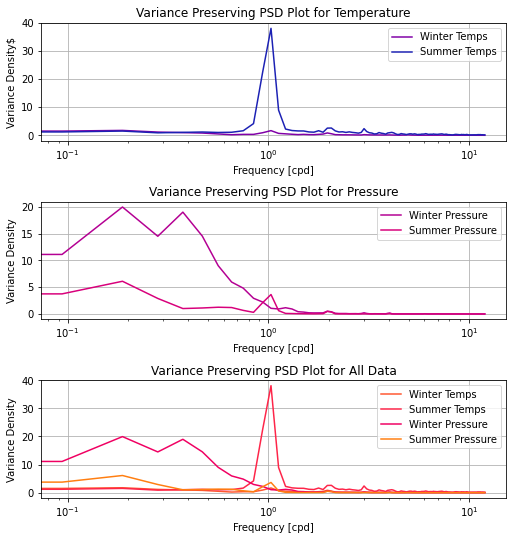

In [10]:
# variance densities:

pxx_htw_vd = np.array(freq_htw) * np.array(pxx_htw)  ; 
pxx_hts_vd = np.array(freq_hts) * np.array(pxx_hts)  ; 

pxx_hpw_vd = np.array(freq_hpw) * np.array(pxx_hpw)  ; 
pxx_hps_vd = np.array(freq_hps) * np.array(pxx_hps)  ;



# plots the four power spectral densities overlayed on each other:

# colours:

ccc=['#1c21b4','#8000a7','#b40093','#d8007b','#f00062','#fe2549','#ff5730','#ff7e11']

width=8
height=8
ff, (ax1,ax2,ax3) = plt.subplots(3,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)

ax1.semilogx(freq_htw, pxx_htw_vd, color=ccc[1], label="Winter Temps")
ax1.semilogx(freq_hts, pxx_hts_vd, color=ccc[0], label="Summer Temps")
ax1.set_title("Variance Preserving PSD Plot for Temperature")
ax1.set_ylabel(r"Variance Density$")
ax1.set_xlabel("Frequency [cpd]")
ax1.legend()
ax1.grid(True)

ax2.semilogx(freq_hpw, pxx_hpw_vd, color=ccc[2], label="Winter Pressure")
ax2.semilogx(freq_hps, pxx_hps_vd, color=ccc[3], label="Summer Pressure")
ax2.set_title("Variance Preserving PSD Plot for Pressure")
ax2.set_ylabel(r"Variance Density")
ax2.set_xlabel("Frequency [cpd]")
ax2.legend()
ax2.grid(True)

ax3.semilogx(freq_htw, pxx_htw_vd, color=ccc[6], label="Winter Temps")
ax3.semilogx(freq_hts, pxx_hts_vd, color=ccc[5], label="Summer Temps")
ax3.semilogx(freq_hpw, pxx_hpw_vd, color=ccc[4], label="Winter Pressure")
ax3.semilogx(freq_hps, pxx_hps_vd, color=ccc[7], label="Summer Pressure")
ax3.set_title("Variance Preserving PSD Plot for All Data")
ax3.set_ylabel(r"Variance Density")
ax3.set_xlabel("Frequency [cpd]")
ax3.legend()
ax3.grid(True)

We now wish to test Parseval's theorem for the temperature data sets. Parseval's theorem tells us the following:

$$
\int_{-\infty}^{\infty} x^2(t)dt = \frac{1}{2\pi} \int_{-\infty}^{\infty} | X(f)|^2df
$$

We also have, ideally, the the power spectrum of the signal is $\Gamma(f)=| X(f)|^2 $ and so using the result from part c we arrive at:

$$
\int_{-\infty}^{\infty} x^2(t)dt = \frac{1}{2\pi} \int_{-\infty}^{\infty} | X(f)|^2df \approx \frac{1}{2\pi} \int_{f_{min}}^{f_{max}}\Gamma(f)df = \sigma^2_x
$$

This can also be extended nicely to the discrete data case as follows:

$$
\frac{1}{N} \sum_{r=-n}^{n-1} s_r^2 = \frac{1}{2\pi}\sum_{m=-n}^{n-1} |S_m|^2
$$

In [11]:
# To test, we need to find the value of either the above integrals or sums. One can approximate 
# them using a built in integrating routine or by summing up. 
# Also the time series sum and variance will be found below:

# this analysis is likely sensitive to the removed nan values
# and so to get some semblance of range for the test, we will use
# the upper and lower bounds to get ~ range of variance values:

# we first just find the variance of the original signal for each:

var_ntw = (np.std(rvyc_ntw))**2
var_nts = (np.std(rvyc_nts))**2

# next, the sum of the time series in time domain, lhs of the above eq:

ser_sum_tw = (1/len(rvyc_ntw))*sum(np.array(rvyc_ntw)**2)
ser_sum_ts = (1/len(rvyc_nts))*sum(np.array(rvyc_nts)**2)

# third, the sum of the spectra in the frequency domain, rhs of above:

psd_sum_tw = sum(abs(np.array(pxx_htw)))/(2*np.pi)
psd_sum_ts = sum(abs(np.array(pxx_hts)))/(2*np.pi)

# Finally, we find a range in the above sum by repeating within the 
# uncertainty ranges:

psd_sum_tw_l = sum(abs(np.array(pxx_htw_l)))/(2*np.pi)
psd_sum_tw_u = sum(abs(np.array(pxx_htw_u)))/(2*np.pi)

psd_sum_ts_l = sum(abs(np.array(pxx_hts_l)))/(2*np.pi)
psd_sum_ts_u = sum(abs(np.array(pxx_hts_u)))/(2*np.pi)

# the results of the discrete case can be seen below:

print("The Winter Data Set is summarized here:")
print("--------------------------------------------------------------")
print(f"The Variance was found to be : {var_ntw:0.3f}")
print(f"The Series sum in time domain was found to be : {ser_sum_tw:0.3f}")
print(f"The PSD sum in the frequency domain was : {psd_sum_tw:0.3f}")
print()
print(f"The range in acceptable sum(PSD) is given below :")
print(f"{psd_sum_tw_u:0.3f} < sum of PSD Values < {psd_sum_tw_l:0.3f}")
print("--------------------------------------------------------------")
print()
print("The Summer Data Set is summarized here:")
print("--------------------------------------------------------------")
print(f"The Variance was found to be : {var_nts:0.3f}")
print(f"The Series sum in time domain was found to be : {ser_sum_ts:0.3f}")
print(f"The PSD sum in the frequency domain was : {psd_sum_ts:0.3f}")
print()
print(f"The range in acceptable sum(PSD) is given below :")
print(f"{psd_sum_ts_u:0.3f} < sum of PSD Values < {psd_sum_ts_l:0.3f}")
print("--------------------------------------------------------------")
print()

# analysis will follow

The Winter Data Set is summarized here:
--------------------------------------------------------------
The Variance was found to be : 6.492
The Series sum in time domain was found to be : 6.492
The PSD sum in the frequency domain was : 7.073

The range in acceptable sum(PSD) is given below :
4.140 < sum of PSD Values < 14.750
--------------------------------------------------------------

The Summer Data Set is summarized here:
--------------------------------------------------------------
The Variance was found to be : 15.337
The Series sum in time domain was found to be : 15.337
The PSD sum in the frequency domain was : 21.498

The range in acceptable sum(PSD) is given below :
12.583 < sum of PSD Values < 44.830
--------------------------------------------------------------



The variance and the series sums in both the summer and winter yielded almost identical values. This is expected as we have zero mean ergodic data sets and so the sum in the square of the components should give the variance. The sum of power spectral density components is slightly more interesting as it is not identically the same as the variance as ~ expected. To account for this, the range allowed by the upper and lower bound within a 95% confidence level in variance were included. It is clear that for both the winter and summer data sets, the PSD sum falls well within the bounds set by this confidence interval. Thus, we can conclude that Parseval's theorem holds in both seasons within the uncertainty provided. 

### Question 2. Filter design
* 1.  * a) Derive a frequency-domain Butterworth low-pass filter H(ω) with attenuation at ω =
        2.0ωc that is 48 dB down compared to the signal at ω = 0. (Show individual steps.)
       * b) What would be the attenuation for such a filter with order n = 4?
       * c) Sketch H(ω) for both cases.
       * d) Briefly explain how the result using a Butterworth filter compares to using a rectangular
         low-pass filter.

a) We begin first with the expression for a low pass butterworth filter:

$$
|H(f)|^2 = \frac{1}{1+\left(\frac{f}{f_L}\right) ^{2n}} \longrightarrow \frac{1}{1+\left(\frac{\omega}{\omega_c}\right) ^{2n}}
$$

To design a filter, we need to find the requisite order of the filter using the given information. First, we want the attenuation in terms of the cutoff frequency to be $\omega=2.0\omega_c$. This corresponds to a decrease (in decibels) of 48. 

So at the cutoff frequency, $\omega_c$, where we have attenuation we have:

$$
|H(\omega_c)|^2 = \frac{1}{1+\left(\frac{2\omega_c}{\omega_c}\right) ^{2n}}
$$

We also know by definition that:

$$
dB \ level = 10log_{10}\left(\frac{Power}{Reference \ Power} \right)
$$

With a decibel decrease at the requisite frequency of $-48dB$ and a reference power at $\omega=0$, the decibel expression w.r.t $\omega = 2\omega_c$ is:


$$
dB \ level = -48 \ dB = 10log_{10}\left(\frac{\frac{1}{1+\left(\frac{2\omega_c}{\omega_c}\right) ^{2n}}}{\frac{1}{1+0}} \right)
$$

$$
-48 \ dB = 10log_{10}\left(\frac{1}{1+\left(2\right) ^{2n}} \right)
$$

$$
48 \ dB = 10log_{10}\left(1+2^{2n}\right)
$$

If we now unlog the above expression we arrive at:

$$
10^{4.8} = 2^{2n} +1
$$

After some more algebra:

$$
n = \frac{1}{2} log_{2}(10^{4.8}-1)
$$

Evaluating this expression above gives a value for n such that:

$$
n \approx 7.973
$$

We do not necessarily care about the floor of this number for the filter order and it is safe to approximate this to be ~8. This finally leaves us with a low-pass butterworth filter of the form:

$$
H(\omega) = \frac{1}{\sqrt{1+\left( \frac{\omega}{\omega_c}\right)^{16}}}
$$

b) In this problem, we must reverse the process undertaken above. First setting n = 4:

$$
H(\omega) = \frac{1}{\sqrt{1+\left( \frac{\omega}{\omega_c}\right)^{8}}} \longrightarrow 
|H(\omega)|^2 = \frac{1}{1+\left( \frac{\omega}{\omega_c}\right)^{8}}
$$

With all other properties of the filtering held constant to part a), we can again consider the ddecibel response with respect to both the power at $\omega=2\omega_c$ and $\omega=0$:

$$
dB \ level = 10log_{10}\left(\frac{Power}{Reference \ Power} \right) =10log_{10}\left(\frac{\frac{1}{1+\left( \frac{2\omega_c}{\omega_c}\right)^{8}}}{\frac{1}{1+\left( 0\right)^{8}}} \right)
$$

Which results in:

$$
dB \ level = -10log_{10}\left( 2^8+1\right)
$$

Evaluating this yields a value of :

$$
dB \ level = -24.099 \approx -24 dB
$$

Thus, the attenuation of a fourth order butterworth filter with these properties would be $\approx -24dB$.

c) Our two filters are of the form:

$$
H_8(\omega) = H(\omega) = \frac{1}{\sqrt{1+\left( \frac{\omega}{\omega_c}\right)^{16}}}; \ \ H_4{\omega}=\frac{1}{\sqrt{1+\left( \frac{\omega}{\omega_c}\right)^{8}}}
$$

Since we are working in the Notebook Environment, the two filters will just be plotted in python with the critical points and values labelled:


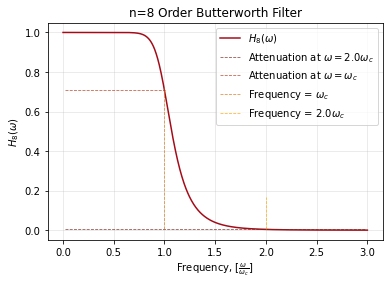

In [70]:
# first make a frequency vector and arbitrary cutoff frequency:

w_cut = 1; ws = np.linspace(0,3*w_cut, 1000)

h_8 = lambda w: 1 / (np.sqrt(1+(w/w_cut)**(16)))
h_4 = lambda w: 1 / (np.sqrt(1+(w/w_cut)**(8)))

attent_8 = 1/np.sqrt(1+2**16); attent_4 = 1/np.sqrt(1+2**8)

# plots the eighth order filter:

ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.plot(ws, h_8(ws), color='#a40b18', label=r"$H_8(\omega)$")
ax1.set_title("n=8 Order Butterworth Filter")
ax1.axhline(y=attent_8, xmin=0.05,xmax=0.95, linestyle='--',linewidth=0.8, color='#7b2518', alpha=0.8, label=r"Attenuation at $\omega=2.0\omega_c$")
ax1.axhline(y=1/np.sqrt(2), xmin=0.05,xmax=0.35, linestyle='--',linewidth=0.8, color='#b83816', alpha=0.8, label=r"Attenuation at $\omega=\omega_c$")
ax1.axvline(x=w_cut, ymin=0.05, ymax=0.7,linestyle='--',linewidth=0.8, color='#d97617', alpha=0.8,label=r"Frequency = $\omega_c$")
ax1.axvline(x=2*w_cut, ymin=0.05, ymax=0.2,linestyle='--',linewidth=0.8, color='#ffa600', alpha=0.8,label=r"Frequency = $2.0\omega_c$")
ax1.set_xlabel(r"Frequency, $ [\frac{\omega}{\omega_c}]$")
ax1.set_ylabel(r"$H_8(\omega)$" )
ax1.legend()
ax1.grid(True, alpha=0.3)

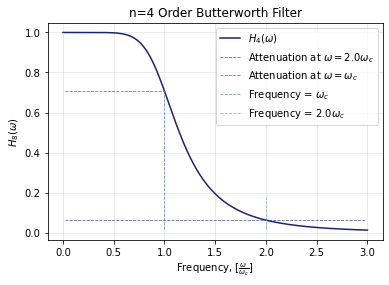

In [92]:
# plots the fourth order filter:

ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.plot(ws, h_4(ws), color='#1a2081', label=r"$H_4(\omega)$")
ax1.set_title("n=4 Order Butterworth Filter")
ax1.axhline(y=attent_4, xmin=0.05,xmax=0.95, linestyle='--',linewidth=0.8, color='#283f9f', alpha=0.8, label=r"Attenuation at $\omega=2.0\omega_c$")
ax1.axhline(y=1/np.sqrt(2), xmin=0.05,xmax=0.35, linestyle='--',linewidth=0.8, color='#395fbc', alpha=0.8, label=r"Attenuation at $\omega=\omega_c$")
ax1.axvline(x=w_cut, ymin=0.05, ymax=0.7,linestyle='--',linewidth=0.8, color='#4c7ed9', alpha=0.8,label=r"Frequency = $\omega_c$")
ax1.axvline(x=2*w_cut, ymin=0.05, ymax=0.2,linestyle='--',linewidth=0.8, color='#639ff4', alpha=0.8,label=r"Frequency = $2.0\omega_c$")
ax1.set_xlabel(r"Frequency, $ [\frac{\omega}{\omega_c}]$")
ax1.set_ylabel(r"$H_8(\omega)$" )
ax1.legend()
ax1.grid(True, alpha=0.3)

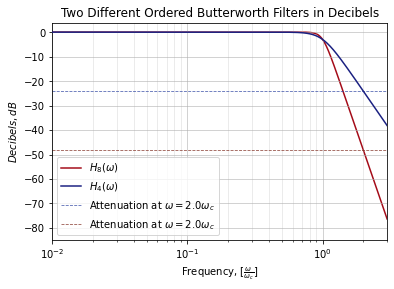

In [109]:
# and in a logarithmic form:

# plots the fourth order filter:

ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.semilogx(ws, 20*np.log10(h_8(ws)), color='#a40b18', label=r"$H_8(\omega)$",zorder=0)
ax1.semilogx(ws, 20*np.log10(h_4(ws)), color='#1a2081', label=r"$H_4(\omega)$",zorder=5)
ax1.axhline(y=20*np.log10(attent_4), xmin=0,xmax=1, linestyle='--',linewidth=0.8, color='#283f9f', alpha=0.8, label=r"Attenuation at $\omega=2.0\omega_c$")
ax1.axhline(y=20*np.log10(attent_8), xmin=0.0,xmax=1, linestyle='--',linewidth=0.8, color='#7b2518', alpha=0.8, label=r"Attenuation at $\omega=2.0\omega_c$")

ax1.set_title("Two Different Ordered Butterworth Filters in Decibels")
ax1.set_xlabel(r"Frequency, $ [\frac{\omega}{\omega_c}]$")
ax1.set_ylabel(r"$Decibels, dB$" )
ax1.set_xlim(0.01,3)
ax1.set_ylim(-85)
ax1.legend()
ax1.grid(which='minor', alpha=0.3)
ax1.grid(which='major', alpha=0.7)


d) A rectangular filter will "ideally" cut off unwanted frequencies and would have no attenuation when compared to the result above. This is because a boxcar would just cut off the frequencies higher than a certain point and set them to zero. When tranformed back into the time domain with a rectangular filter, we would experience a high level of contamination due to the sharp cutoff. For a butterworth filter, this effect is diminished but there is attenuation found as the filter tapers in its cutoff range. A lower order filter, like order 4 compared to order 8, will have a smoother transition region and so less attenutation at a specified frequency. Higher order butterworths will approach a rectangular filter in the limit of n increasing and so the attenuation would increase with an increase in frequency contamination. 

### Question 3. Filtering of synthetic data
Generate a discrete sampled time series, with $N = 3 × 10^4$
equally-spaced data points, that
approximates the following function:

x(t) = x1(t) + 0.7 sin(a2πt) + 0.5 sin(a3πt); −15s < t ≤ 15s, (1)

with x1(t) = cos(a1πt) and a1 = 25, a2 = 16, a3 = 143.
   * 1. For the following you may use standard signal processing functions (e.g. pwelch.m, butter.m,
      freqz.m, filtfilt.m or their equivalents in Python). Please include your code.
     * a) Plot x(t); −1s ≤ t ≤ 1s
     * b) Plot the power density spectrum of x(t), including the 95% confidence limits.
     * c) Using a Butterworth filter in the time domain, try to recover x1(t) from x(t). (You may
       design the filter, or use trial and error). Give filter order n and cut-off frequencies. Plot
       the frequency response |H(ω)| of the filter.
     * d) Plot the power density spectra of the filtered time series xf (t) (i.e. your recovered approximation of x1(t)) and of the original x(t) on           the same figure, including the 95%
         confidence limits.
     * e) Plot xf (t) − x1(t); −15s < t ≤ 15s
     * f) Create a rectangular filter in the frequency domain, HR(ω), that recovers x1(t) from x(t).
       Plot HR(ω) and filter the data in the frequency domain.
     * g) Repeat d) and e) with the rectangular frequency domain filter.

In [13]:
# we begin first by defining the requisite functions x(t) and x_1(t):

def x_1_t(t, a1=25):
    '''
    Takes input time vector t
    and coefficient a1 and 
    returns the function value 
    x1(t)
    '''
    func_val = np.cos(a1*np.pi*t)
    return func_val

def x_t(t, a1=25, a2=16, a3=143):
    '''
    Takes input time vector t
    and coefficients a1,a2,a3 and
    returns the function value
    x(t)
    '''
    func_val = x_1_t(t,a1=a1) + 0.7 * np.sin(a2*np.pi*t) + 0.5 * np.sin(a3*np.pi*t)
    
    return func_val

In [14]:
# we now wish to evaluate the function x(t) in the interval -15<t<15 with 3*10^4 points:

N = 3 * 10**4; tmin = -15; tmax = 15;

teval = np.linspace(tmin, tmax, N)

x_data = x_t(teval)

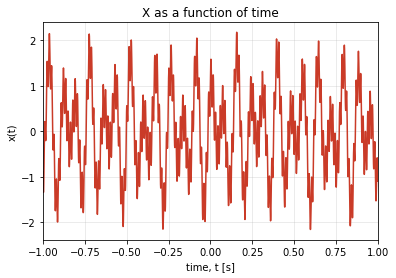

In [116]:
# plotting the above function in the range -1<t<1:

ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.plot(teval,x_data, color='#ca3b28')
ax1.set_title("X as a function of time")
ax1.set_xlabel(r"time, t [s]")
ax1.set_ylabel(r"x(t)" )
ax1.set_xlim(-1,1)
ax1.grid(True, alpha=0.3)

In [138]:
# the power density spectrum will now be found with a 95% confidence limit. 
# This will be done using the same method from question 1:

# parameters of the functions: (there is 30000 total points)

# first, number of window segments is most important.
# set up to be 8 for this example (NS >=8 is desired):

NS = 8

# we can then find an expression that generalizes the length of 
# each window as the nearest power of two:

floor = int(np.log2(len(x_data)/NS))

nfft = 2**floor # length of the points in each window
fsamp = N / (abs(tmax)+abs(tmin))  # samples per second 
window = "hann"  # type of window used
overlap = nfft/2  # 50% overlap

# we can now consider uncertainty limits in the same way as Q1.

confidence = 0.95
alp = 1 - confidence

# degrees of freedom correspond to number of realizations
# from the Welch method before, using 4/3 factor as it is tapered window:

M = (2*NS - 1); DOF = (4/3) * M

invchi2 = chi2.ppf([alp / 2, 1 - alp / 2], df=DOF)

bounds = DOF/invchi2

# now the frequency and power spectral densities are given by the welch method:

freq_x, pxx_x = signal.welch(x_data, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)

# upper and lower bounds on the uncertainty limits:

pxx_x_l = bounds[0] * pxx_x
pxx_x_u = bounds[1] * pxx_x

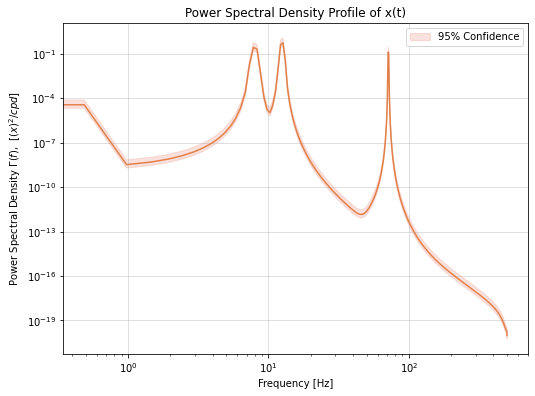

In [139]:
# plots the power spectral densities:

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)

ax1.loglog(freq_x, pxx_x, color='#e18048')
ax1.fill_between(freq_x, pxx_x_l, pxx_x_u, color='#ea6b58',alpha=0.2, label="95% Confidence")
ax1.set_title("Power Spectral Density Profile of x(t)")
ax1.set_ylabel(r"Power Spectral Density $\Gamma(f)$,  $ [(x)^2/cpd]$")
ax1.set_xlabel("Frequency [Hz]")
ax1.legend()
ax1.grid(True, alpha=0.5)




In [140]:
# the next step is to filter out the spike due to x_1(t) which should result
# in recovering that part of the signal. We must then design a bandpass filter 
# that will complete this task:

# The position of the spike will occur at the frequency of the cosine wave, or:

x_1_freq = 25 * np.pi / (2*np.pi) # = 12.5 Hz

# To isolate this spike, we must apply a filter around it. We can go about this
# a number of different ways. The full-width-half-max of the spike in a linear plot
# seems to be around 1.25. We can then set the filter width to be ~2.5 Hz. 
# Alternatively, we can also set the band pass width to be ~half of the distance to the 
# next spike, or about 5 Hz. The efficacy of these choices will be explored using 
# trial and error:

half_width_filt = 1.25 # Hz

lowpass = x_1_freq - half_width_filt
highpass = x_1_freq + half_width_filt

filt_order = 5 # will change by trial and error

# butterworth filter:

b,a = signal.butter(filt_order, [lowpass,highpass],'bandpass',analog=True, )


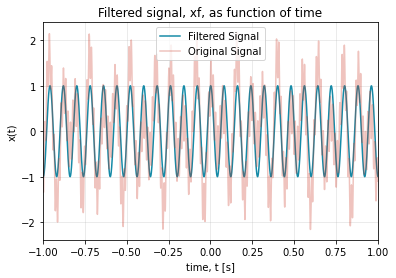

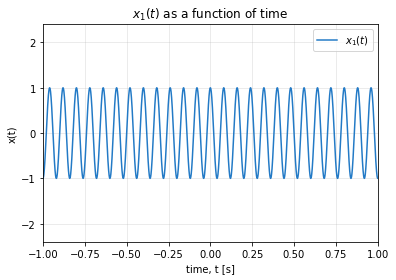

In [439]:
# using the filter we can hope to extract the signal x1:

sos = signal.butter(filt_order, [lowpass,highpass],'bandpass',fs=fsamp, output='sos')

x_f_data = signal.sosfilt(sos,x_data)

# plotting the above function in the range -1<t<1 with original overlayed:

ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.plot(teval,x_f_data, color='#158aa7', label="Filtered Signal")
ax1.plot(teval,x_data, color='#ca3b28', alpha=0.3, label="Original Signal")
ax1.set_title("Filtered signal, xf, as function of time")
ax1.set_xlabel(r"time, t [s]")
ax1.set_ylabel(r"x(t)" )
ax1.set_xlim(-1,1)
ax1.legend()
ax1.grid(True, alpha=0.3)

# plots x_1(t) for comparison:


ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.plot(teval,x_1_data, color='#237ac6', alpha=1, label=r"$x_1(t)$")
ax1.set_title(r"$x_1(t)$ as a function of time")
ax1.set_xlabel(r"time, t [s]")
ax1.set_ylabel(r"x(t)" )
ax1.set_xlim(-1,1)
ax1.set_ylim(-2.4,2.4)
ax1.legend()
ax1.grid(True, alpha=0.3)

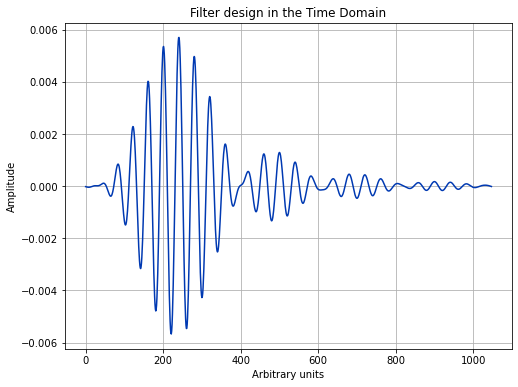

In [240]:
# plots the filter in the time domain:

# frequencies of the butterworth filter:

freq_but, amp_but = signal.sosfreqz(sos, worN=1048)

# inverse fourier to go back to time domain
time_filt = np.fft.ifft(amp_but)

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.plot((time_filt.real), color='#0039b2')
ax1.set_title("Filter design in the Time Domain")
ax1.set_xlabel("Arbitrary units")
ax1.set_ylabel("Amplitude")
#ax1.set_xlim(-1,1)
#ax1.set_ylim(-2,2)
ax1.grid()

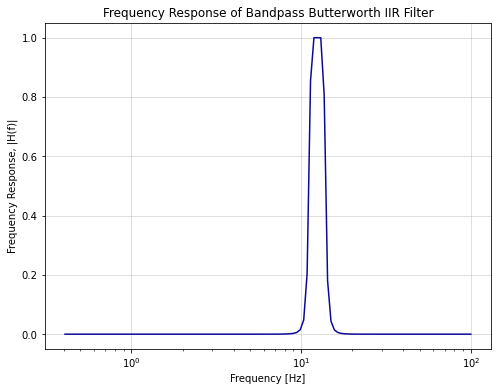

In [241]:
# we now wish to plot the frequency response of this filter. Can be found by simply 
# using the freqs function built in to scipy:

freqs, f_resp = signal.freqs(b,a)

# only wish to plot in region where the power spectrum is defined:
# and the absolute value of the filter response:

freqs_plot = freqs[80:]; f_resp_plot=abs(f_resp[80:])

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.semilogx(freqs_plot, f_resp_plot, color='#0c0898')
ax1.set_title("Frequency Response of Bandpass Butterworth IIR Filter")
ax1.set_ylabel(r"Frequency Response, |H(f)|")
ax1.set_xlabel("Frequency [Hz]")

ax1.grid(True, alpha=0.5)

In [144]:
# We now need to find the power density spectra of our filtered signal:

# will simply use the same welch method as used prior with uncertainty:

NS = 8 # number of segments

floor = int(np.log2(len(x_f_data)/NS))
nfft = 2**floor # length of the points in each window
fsamp = N / (abs(tmax)+abs(tmin))  # samples per second 
window = "hann"  # type of window used
overlap = nfft/2  # 50% overlap

confidence = 0.95; alp = 1 - confidence

M = (2*NS - 1); DOF = (4/3) * M
invchi2 = chi2.ppf([alp / 2, 1 - alp / 2], df=DOF)

bounds = DOF/invchi2

# now the frequency and power spectral densities are given by the welch method:

freq_x_f, pxx_x_f = signal.welch(x_f_data, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)

# upper and lower bounds on the uncertainty limits:

pxx_x_f_l = bounds[0] * pxx_x_f
pxx_x_f_u = bounds[1] * pxx_x_f

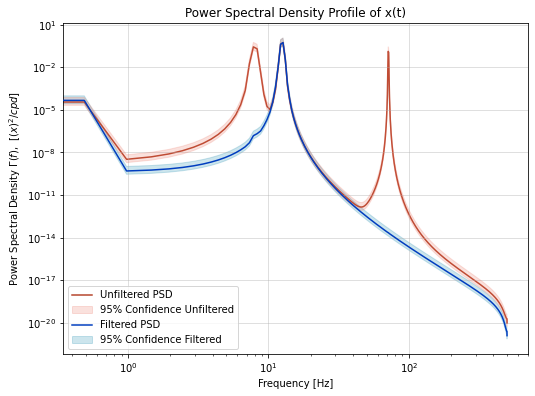

In [158]:
# plots the power spectral densities of both x data:

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)

ax1.loglog(freq_x, pxx_x, color='#b5442b', label="Unfiltered PSD",zorder=1)
ax1.fill_between(freq_x, pxx_x_l, pxx_x_u, color='#ea6b58',alpha=0.2, label="95% Confidence Unfiltered",zorder=2)

ax1.loglog(freq_x_f, pxx_x_f, color='#003dbf', label="Filtered PSD",zorder=5)
ax1.fill_between(freq_x_f, pxx_x_f_l, pxx_x_f_u, color='#007ea6',alpha=0.2, label="95% Confidence Filtered",zorder=0)

ax1.set_title("Power Spectral Density Profile of x(t)")
ax1.set_ylabel(r"Power Spectral Density $\Gamma(f)$,  $ [(x)^2/cpd]$")
ax1.set_xlabel("Frequency [Hz]")
ax1.legend(loc=3)
ax1.grid(True, alpha=0.5)

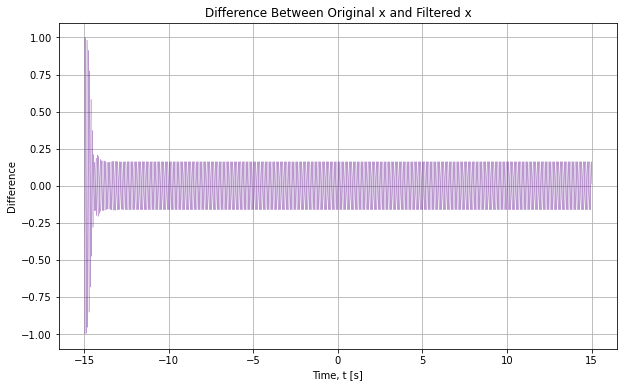

In [242]:
# the next step is to plot the difference between the extracted function
# and the defined function x1(t):

x_1_data = x_1_t(teval)

x_diff = x_f_data - x_1_data

# plots the difference for t E [-15,15]:

width=10
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.plot(teval, x_diff, color='#560089', linewidth=0.2)
ax1.set_title("Difference Between Original x and Filtered x")
ax1.set_xlabel("Time, t [s]")
ax1.set_ylabel("Difference")
ax1.set_xlim()
ax1.grid()

In [424]:
# we now want to design a rectangular filter in the frequency domain
# that attempts to accomplish the same as the butterworth filter from before:

# can do this by defining a rectangle function as follows:

def rect_filt(fs, minf, maxf):
    '''
    Takes a list of frequencies, fs,
    as an argument and returns the value 1 
    if a given frequency is between 
    the min frequency or max frequency
    
    We must also consider negative frequencies
    and so 1 at the negative counterpart
    '''
    
    if fs >=0:
        if (fs < minf):
            return 0
        elif (fs > maxf):
            return 0
        elif (minf <= fs <= maxf):
            return 1
    else:                     # this accounts for the negative freqs
        if (fs>-minf):
            return 0
        elif (fs < -maxf):
            return 0
        elif (-minf >= fs >= -maxf):
            return 1


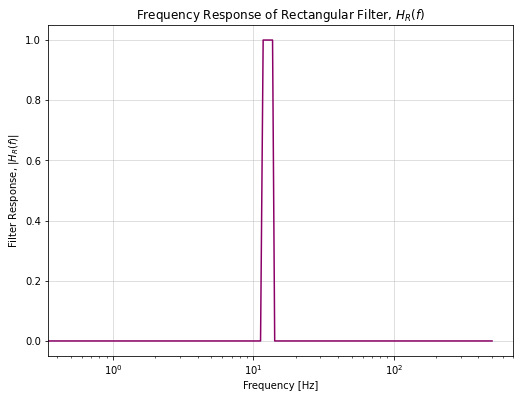

In [425]:
# plots the rectangular filter:

lower = lowpass; higher = highpass

rect_filter = [rect_filt(fi, lower,highpass) for fi in freq_x]


width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)

ax1.semilogx(freq_x, rect_filter, color='#8a0067')
ax1.set_title(r"Frequency Response of Rectangular Filter, $H_R(f)$")
ax1.set_ylabel(r"Filter Response, $|H_R(f)|$")
ax1.set_xlabel("Frequency [Hz]")
ax1.grid(True, alpha=0.5)

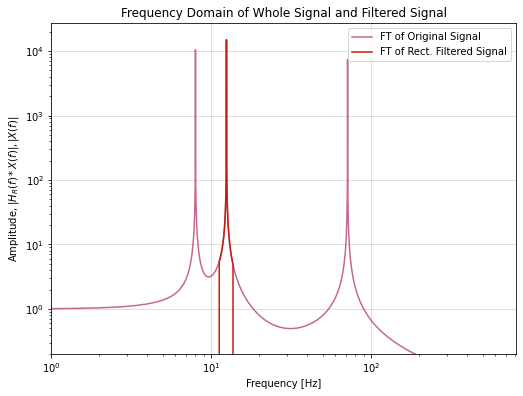

In [426]:
# must now apply the filter to the original function. Since we are operating 
# in the frequency domain we can simply just multiply this filter with
# the frequency response of the original function x(t). But to do this
# we must take the fourier transform of x(t):

# first FT and frequencies of the original signal:

x_ft = np.fft.fft(x_data); og_x_freqs = np.fft.fftfreq(len(x_data), 1/fsamp)

# full rectangular filter for all points in the original:

rect_fil_full = [rect_filt(fi, lower,highpass) for fi in og_x_freqs]

# now need to multiply this FT with our filter from above:

x_rf_data = np.multiply(x_ft, rect_fil_full)

# plots the original FT and the filtered FT:

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)

ax1.loglog(og_x_freqs, abs(x_ft), color='#a10049', alpha=0.6, label="FT of Original Signal")

ax1.loglog(og_x_freqs, abs(x_rf_data), color='#c61d0b', label="FT of Rect. Filtered Signal")

ax1.set_title(r"Frequency Domain of Whole Signal and Filtered Signal")
ax1.set_ylabel(r"Amplitude, $|H_R(f)*X(f)|, |X(f)|$")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylim(0.2)
ax1.set_xlim(1)
ax1.legend()
ax1.grid(True, alpha=0.5)



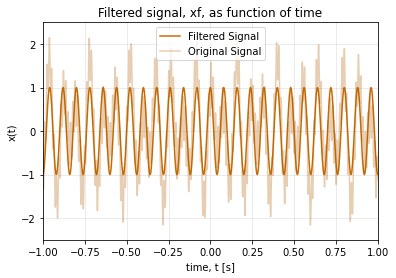

In [427]:
# To check if original signal is recovered, the inverse FT
# and the original signal are overlayed:

inv_x_rf = np.real(np.fft.ifft(x_rf_data))


ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(6)
ff.set_figheight(4)

ax1.plot(teval,inv_x_rf, color='#c66c05', label="Filtered Signal")
ax1.plot(teval,x_data, color='#b25c00', alpha=0.3, label="Original Signal")
ax1.set_title("Filtered signal, xf, as function of time")
ax1.set_xlabel(r"time, t [s]")
ax1.set_ylabel(r"x(t)" )
ax1.set_xlim(-1,1)
ax1.set_ylim(-2.5,2.5)
ax1.legend()
ax1.grid(True, alpha=0.3)

In [428]:
# we now need to find the power density spectra for the above filtered
# signal and overlay that with the baseline established prior:

# will simply use the same welch method as used prior with uncertainty:

NS = 8 # number of segments

floor = int(np.log2(len(x_rf_data)/NS))
nfft = 2**floor # length of the points in each window
fsamp = N / (abs(tmax)+abs(tmin))  # samples per second 
window = "hann"  # type of window used
overlap = nfft/2  # 50% overlap

confidence = 0.95; alp = 1 - confidence

M = (2*NS - 1); DOF = (4/3) * M
invchi2 = chi2.ppf([alp / 2, 1 - alp / 2], df=DOF)

bounds = DOF/invchi2

# now the frequency and power spectral densities are given by the welch method:

freq_x_rf, pxx_x_rf = signal.welch(inv_x_rf, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)

# upper and lower bounds on the uncertainty limits:

pxx_x_rf_l = bounds[0] * pxx_x_rf
pxx_x_rf_u = bounds[1] * pxx_x_rf

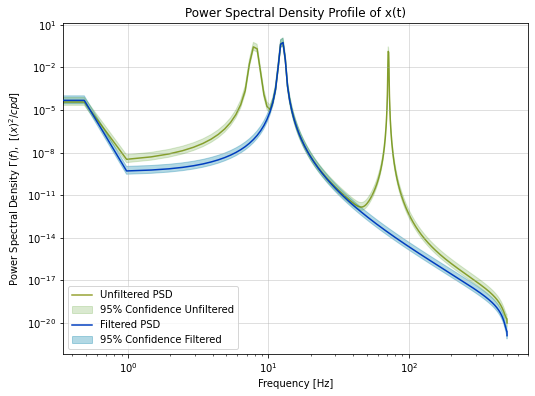

In [429]:
# plots the power spectral densities of both x data:

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)

ax1.loglog(freq_x, pxx_x, color='#7c8b00', label="Unfiltered PSD",zorder=1, alpha=0.8)
ax1.fill_between(freq_x, pxx_x_l, pxx_x_u, color='#489516',alpha=0.2, label="95% Confidence Unfiltered",zorder=2)

ax1.loglog(freq_x_rf, pxx_x_rf, color='#003dbf', label="Filtered PSD",zorder=5)
ax1.fill_between(freq_x_rf, pxx_x_rf_l, pxx_x_rf_u, color='#007ea6',alpha=0.3, label="95% Confidence Filtered",zorder=0)

ax1.set_title("Power Spectral Density Profile of x(t)")
ax1.set_ylabel(r"Power Spectral Density $\Gamma(f)$,  $ [(x)^2/cpd]$")
ax1.set_xlabel("Frequency [Hz]")
ax1.legend(loc=3)
ax1.grid(True, alpha=0.5)

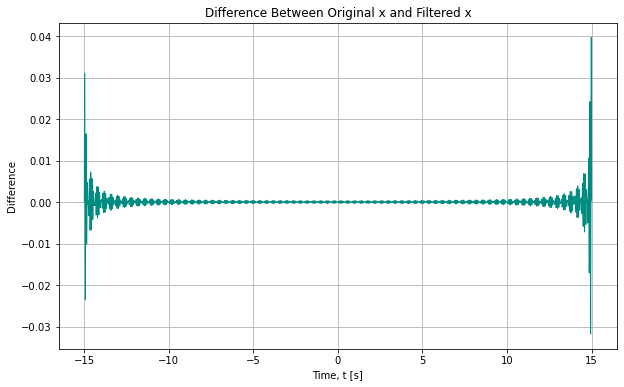

In [431]:
# finally, the difference between this spectrum and the original
# will be found below:

x_1_data = x_1_t(teval)
x_diff = inv_x_rf - x_1_data

# plots the difference for t E [-15,15]:

width=10
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.plot(teval, x_diff, color='#008c80', linewidth=1)
ax1.set_title("Difference Between Original x and Filtered x")
ax1.set_xlabel("Time, t [s]")
ax1.set_ylabel("Difference")
#ax1.set_xlim(-1,1)
#ax1.set_ylim(-2,2)
ax1.grid()